# 0.0 Imports

In [1]:
import pandas             as pd
import numpy              as np
import pandas.io.sql      as sqlio

import matplotlib.pyplot  as plt
import seaborn            as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import psycopg2

from IPython.display import Image

## 0.1 Helper Functions

In [2]:
def create_connection_database(host_name, port_num, database_name, user_name, password_name):
    connection = None
    connection = psycopg2.connect(
                        host = host_name,
                        port = port_num,
                        database = database_name,
                        user = user_name,
                        password = password_name)
    return connection


## 0.2 Loading Data

In [3]:
#connect to the DB
host_name     = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
port_num      = 5432 
database_name = "comunidadedsdb"
user_name     = "member"
password_name = "cdspa"

#make connection with DB
conn = create_connection_database (host_name, port_num, database_name, user_name, password_name)

#checking tables in schema
cur = conn.cursor()

cur.execute("""SELECT table_schema, table_name
                      FROM information_schema.tables
                      WHERE table_schema != 'pg_catalog'
                      AND table_schema != 'information_schema'
                      AND table_type='BASE TABLE'
                      ORDER BY table_schema, table_name""")

schemas_db = cur.fetchall()

# cursor close
cur.close()

df_insurance = sqlio.read_sql_query("Select * from pa004.insurance", conn)
df_vehicle = sqlio.read_sql_query("Select * from pa004.vehicle", conn)
df_users = sqlio.read_sql_query("Select * from pa004.users", conn)

#close the connection
conn.close()

#checking each shape of dataframes
print('Tables shape:\n Insurance: {}\n Vehicle: {}\n Users: {}'.format(df_insurance.shape,df_vehicle.shape, df_users.shape ))

Tables shape:
 Insurance: (381109, 5)
 Vehicle: (381109, 4)
 Users: (381109, 5)


In [4]:
df0 = df_users.merge(df_vehicle, how = 'outer', on='id')
df0 = df0.merge(df_insurance, how = 'outer', on='id')

#cleaning memory of dataframes used to collect data from DB
df_vehicle = None
df_users = None
df_insurance = None

df0.sample(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
165345,165346,Female,34,8.0,124.0,1,1-2 Year,Yes,0,37071.0,206,0
232417,232418,Female,38,4.0,124.0,1,1-2 Year,Yes,0,33243.0,63,0
348300,348301,Male,37,41.0,124.0,1,1-2 Year,Yes,0,40820.0,52,1
111365,111366,Female,28,8.0,152.0,1,< 1 Year,Yes,0,29611.0,59,0
267804,267805,Male,23,3.0,152.0,1,< 1 Year,No,1,54080.0,145,0


# 1.0 Data Description

In [5]:
df1 = df0.copy()

## 1.1 Rename Columns

In [6]:
cols = df1.columns
cols

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

- Columns names already in snake case

## 1.2 Data Dimension

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.3 Data Types

In [8]:
df1['region_code'] = df1['region_code'].astype(np.int64)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(np.int64)
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

- Types are OK:
    - Only numbers (int and float) and categories (object). There is no dates to convert.

## 1.4 Check NAN

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

- There is no NAN in original datas

## 1.5 Fillout NA

Not necessary, as seen in 1.4 section

## 1.6 Columns Description

In [10]:
cols = df1.columns
cols

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')


- **Id**: Customer identifier 
- **Gender**: Gender of customer
- **Age**: Age of customer
- **Driving License**: 0 if customer does not have the permission for drive; 1 if customer has the permission for drive
- **Region Code**: Region code of customer
- **Previously Insured**: 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.
- **Vehicle Age**: Age of vehicle
- **Vehicle Damage**: 0 if customer never got involved in a previous vehicle damage; 1 if customer already had a vehicle damage
- **Annual Premium**: amount paid for health insurance to the company anualy.
- **Policy sales channel**: anonymous code for contact with customer.
- **Vintage**: time (in days) that customer bought his health assurance.
- **Response**: 0 if customer has no interest in product; 1 if customer has interest in product

## 1.7 Descriptive Statistical

In [11]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]

cat_attributes = df1[['driving_license', 'previously_insured', 'vehicle_damage', 'vehicle_age', 'gender', 'region_code', 'policy_sales_channel' ]]

target_atribute = df1['response']

### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency - Mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max()- x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate

m = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


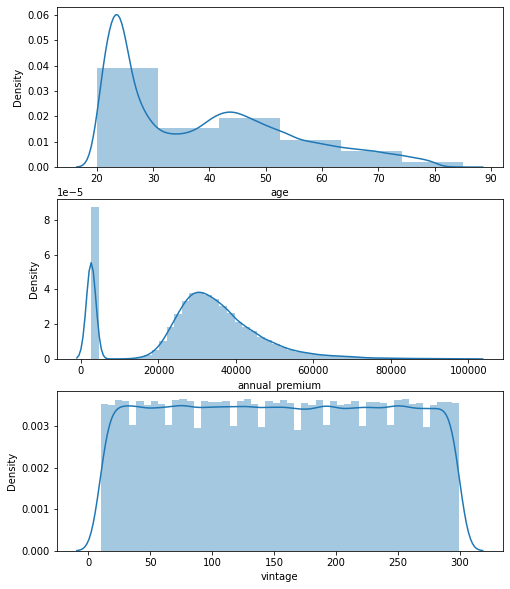

In [65]:
fig, axs = plt.subplots(3, figsize = (8,10))
sns.distplot(df1['age'], ax=axs[0], bins = 6)
sns.distplot(df1[df1['annual_premium']<100000]['annual_premium'], ax=axs[1])
sns.distplot(df1['vintage'], ax=axs[2]);

In [14]:
bins = pd.cut(df1['age'], [19, 30, 40, 50, 60, 70, 80, 90])

df1.groupby(bins)['age'].size().sum()
print('Age analysis:')
print('Percent of 20-29: {}'.format(round((df1.groupby(bins)['age'].size()[0]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 30-39: {}'.format(round((df1.groupby(bins)['age'].size()[1]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 40-49: {}'.format(round((df1.groupby(bins)['age'].size()[2]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 50-59: {}'.format(round((df1.groupby(bins)['age'].size()[3]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 60-69: {}'.format(round((df1.groupby(bins)['age'].size()[4]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 70-79: {}'.format(round((df1.groupby(bins)['age'].size()[5]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 80-85: {}'.format(round((df1.groupby(bins)['age'].size()[6]/df1.groupby(bins)['age'].size().sum()),4)))

Age analysis:
Percent of 20-29: 0.424
Percent of 30-39: 0.145
Percent of 40-49: 0.199
Percent of 50-59: 0.119
Percent of 60-69: 0.073
Percent of 70-79: 0.04
Percent of 80-85: 0.0003


**Data Description Summary for numerical attributes:**

1. **Age** 
    - Range is from 20 to 85. 
    - Mean is 38.82 and median is 36. 
    - Higher density is from 20 to 29 with 42%, followed by 40 to 49 with 19,9%.
****    
2. **Annual_premium**
    - Range is from 2630 to 540165.
    - There is a peak in 2630, and a high density around 20000 to 60000.
****      
3. **Vintage**
    - Range is from 10 to 299.
    - Mean and median are 154. 

### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

driving_license           2
previously_insured        2
vehicle_damage            2
vehicle_age               3
gender                    2
region_code              53
policy_sales_channel    155
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

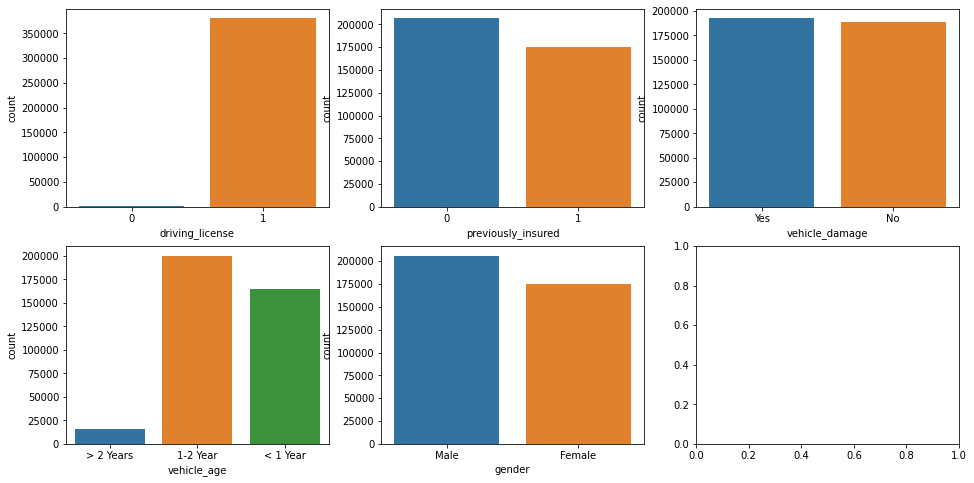

In [16]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (16,8))

sns.countplot(x ='driving_license', data= df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', data=df1, ax=axs[0][1])
sns.countplot(x = 'vehicle_damage', data=df1, ax=axs[0][2])

sns.countplot(x = 'vehicle_age', data=df1,ax=axs[1][0])
sns.countplot(x = 'gender', data=df1,ax=axs[1][1])

In [17]:
sns.countplot(x = 'region_code', data=df1, ax=ax)

NameError: name 'ax' is not defined

In [ ]:
df_policy_1 = df1['policy_sales_channel'].value_counts().iloc[0:55]
df_policy_1 = df_policy_1.reset_index()
df_policy_2 = df1['policy_sales_channel'].value_counts().iloc[55:110]
df_policy_2 = df_policy_2.reset_index()
df_policy_3 = df1['policy_sales_channel'].value_counts().iloc[110:156]
df_policy_3 = df_policy_3.reset_index()

fig, axs = plt.subplots(ncols= 3, figsize = (16,14))
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_1, ax=axs[0],orient = 'h',order = df_policy_1['index'])
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_2, ax=axs[1],orient = 'h',order = df_policy_2['index'])
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_3, ax=axs[2],orient = 'h',order = df_policy_3['index'])

**Data Description Summary for categorical attributes:**

1. **driving_license**
    - 2 categorical: 0 or 1
    - 99,8% is 1 (yes for driving_license)
****  
2. **previously_insured**
    - 2 categorical: 0 or 1
    - 45,8% is 1 (yes for previously_insured)
****
3. **vehicle_damage**
    - only 2 categorical: Yes or No
    - 50,5% is 1 (yes for vehicle_damage)
****
4. **vehicle_age**
    - 3 categorical: < 1 Year, 1-2 Year, > 2 Years
    - 43,2% is < 1 Year
    - 52,6% is 1-2 Year
    - 4,2% is > 2 Years
****
5. **gender**
    - 2 categorical: Male or Female
    - 54,1% is Male
****
6. **region_code**
    - 53 differents categorical region
    - frequency range: 183 to 106415
****
7. **policy_sales_channel**
    - 155 differents categorical of policy_sales_channel
    - frequency range: 1 to 134784

### 1.7.3 Target Atribute

<AxesSubplot:xlabel='response', ylabel='count'>

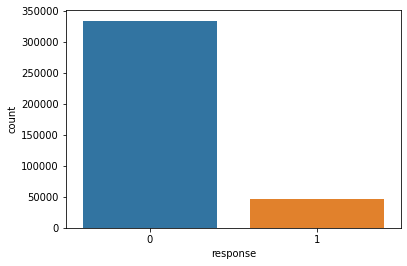

In [18]:
sns.countplot(x = 'response', data=df1)

Based on response descriptive statistical analysis, this variable (our target) is **unbalanced**.

- 87,7% is 0 (negative for interest)
- 12,3 is 1 (positive for interest)

This problem is not about an unbalanced problem as default. 

A balance techinic will be applied to solve this problem.

# 2.0 Feature Engineering And Variables Filtering

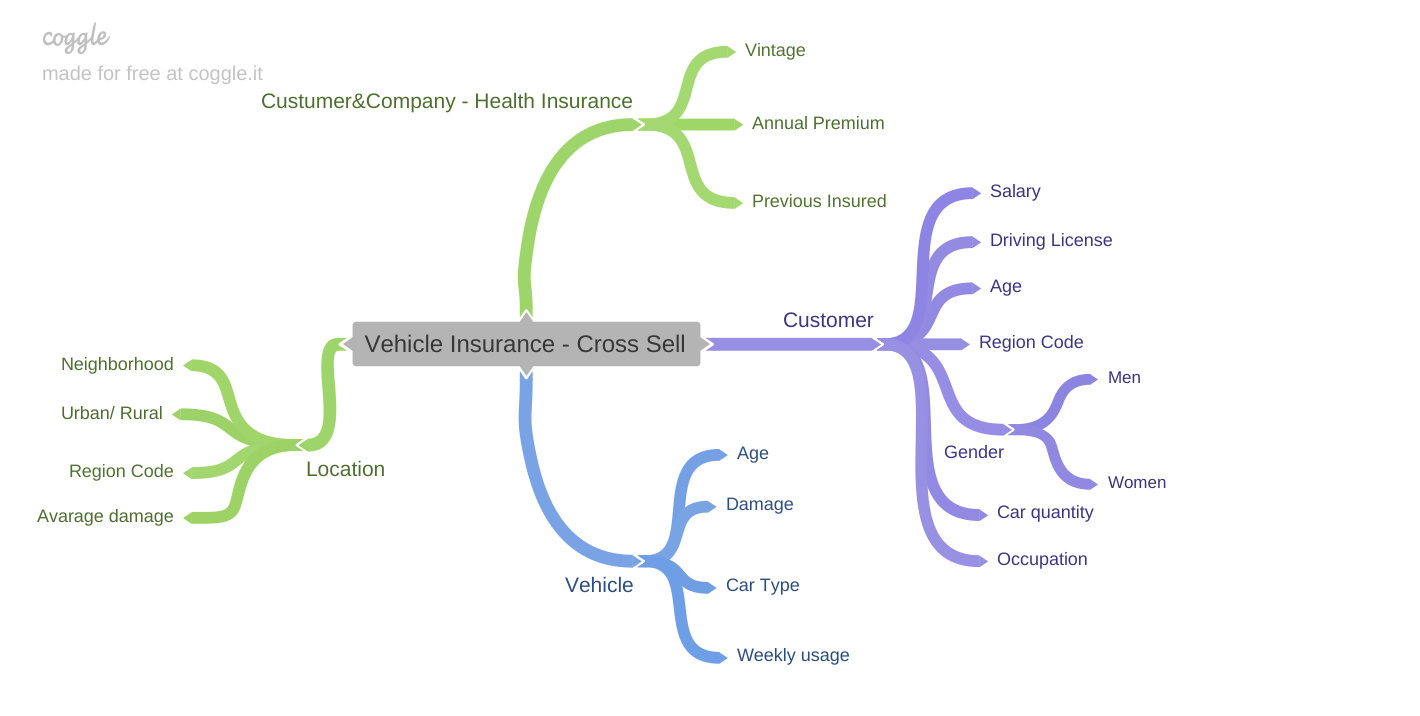

In [20]:
Image ('img/Vehicle_Insurance_Cross_Sell.png')

## 2.1 Hypotheses creation

### 2.1.1 Company's Hypotheses

 **1.** Interest should occur with customer's previous insured
 
 **2.** Interest should occur with customers that spend more than 30k/year with health insurance
 
 **3.** Interest should occur with customers with higher vintage - more than 150 days
****

### 2.1.2 Customer's Hypotheses

 **1.** Interest should occur with older people (more than 40 years)

 **2.** Interest should occur more with female than male (%)

 **3.** Interest should occur with driving license customers
 
 **4.** Interest should occur with customers that have more than one vehicle
 
 **5.** Interest should occur with customers that earn more than $75k/year

****

### 2.1.3 Vehicle's Hypotheses

 **1.** Interest should occur with new vehicles (less than 1 year) 

 **2.** Interest should occur with customer's vehicles previously damaged

 **3.** Interest should occur with customers that use vehicle more than 3 times per week

 **4.** Interest should occur with customers that own sport vehicles
 
****

### 2.1.4 Location's Hypotheses

 **1.** Interest should occur with costumer's violent neighborhood

 **2.** Interest should occur with costumers that live in urban location

 **3.** Interest should occur with costumers that live in a higher avarage damage city


****

## 2.2 Creating New Features

In [206]:
df2 = df1.copy()

In [207]:
#Creating new features


#mapping vechicle_damage from NO to 0 and Yes to 1
vehicle_damage_mapping = {'No':0,
                          'Yes':1}
df2['vehicle_damage'] = df2['vehicle_damage'].map(vehicle_damage_mapping)

#annual_premium paid per day
df2['annual_premium_per_day'] = df2['annual_premium']/df2['vintage']

#annual_premium divided per age
df2['annual_premium_per_age'] = df2['annual_premium']/df2['age']

#vintage_per_age
df2['vintage_per_age'] = df2['vintage']/df2['age']

#logic between previously_insured  and vehicle_damage
df2['previously_insured_vehicle_damage'] =  df2.apply(lambda row: -(row['vehicle_damage'] + row['previously_insured'])**2 if row['previously_insured'] == 0 else (row['vehicle_damage'] + row['previously_insured'])**2, axis=1)

#logic between vehicle_age (consider age > 1 as 1 and age < 1 as 0) and vehicle_damage
df2['vehicle_age_vehicle_damage'] = df2.apply(lambda row: -((row['vehicle_damage'] + 0)**2) if row['vehicle_age'] == '<1 Year' else (row['vehicle_damage'] + 1)**2, axis=1)

#logic between driving_license and vehicle_damage
df2['vehicle_damage_license'] = df2.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)

#logic between annual_premium divided per mean of annual_premium per region_code
df2_annual_premium_mean_region_code = df2.rename(columns={'annual_premium': 'annual_premium_mean'}).groupby('region_code').mean()
df2_annual_premium_mean_region_code.reset_index(inplace=True)
df2 = df2.merge(df2_annual_premium_mean_region_code[['region_code', 'annual_premium_mean']], on='region_code', how='left')
df2['annual_premium_per_ap_mean_rc'] = df2.apply(lambda row: (row['annual_premium']/row['annual_premium_mean']) ,axis=1)
df2.drop(columns='annual_premium_mean', inplace = True)
df2_annual_premium_mean_region_code = None

#logic between annual_premium divided per mean of annual_premium per policy_sales_channel
df2_annual_premium_mean_policy_sales_channel = df2.rename(columns={'annual_premium': 'annual_premium_mean'}).groupby('policy_sales_channel').mean()
df2_annual_premium_mean_policy_sales_channel.reset_index(inplace=True)
df2 = df2.merge(df2_annual_premium_mean_policy_sales_channel[['policy_sales_channel', 'annual_premium_mean']], on='policy_sales_channel', how='left')
df2['annual_premium_per_ap_mean_psc'] = df2.apply(lambda row: (row['annual_premium']/row['annual_premium_mean']) ,axis=1)
df2.drop(columns='annual_premium_mean', inplace = True)
df2_annual_premium_mean_policy_sales_channel = None

#logic of vehicle_damage_mean per region_code
df2_vehicle_damage_mean_per_region_code = df2.rename(columns={'vehicle_damage': 'vehicle_damage_mean_region_code'}).groupby('region_code').mean()
df2_vehicle_damage_mean_per_region_code.reset_index(inplace=True)
df2 = df2.merge(df2_vehicle_damage_mean_per_region_code[['region_code', 'vehicle_damage_mean_region_code']], on='region_code', how='left')

num_attributes = df2[['age', 'annual_premium', 'vintage', 'annual_premium_per_day', 
                         'annual_premium_per_age', 'vintage_per_age',
                         'annual_premium_per_ap_mean_rc', 'annual_premium_per_ap_mean_psc',
                         'vehicle_damage_mean_region_code']]

cat_attributes = df2[['driving_license', 'previously_insured', 'vehicle_damage', 'vehicle_age',
                      'gender', 'region_code', 'policy_sales_channel', 'vehicle_age_vehicle_damage', 
                      'vehicle_damage_license', 'previously_insured_vehicle_damage']]

# 3.0 Exploratory Data Analysis (EDA)

In [ ]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Numerical Attributes

#### 3.1.1.1 Age

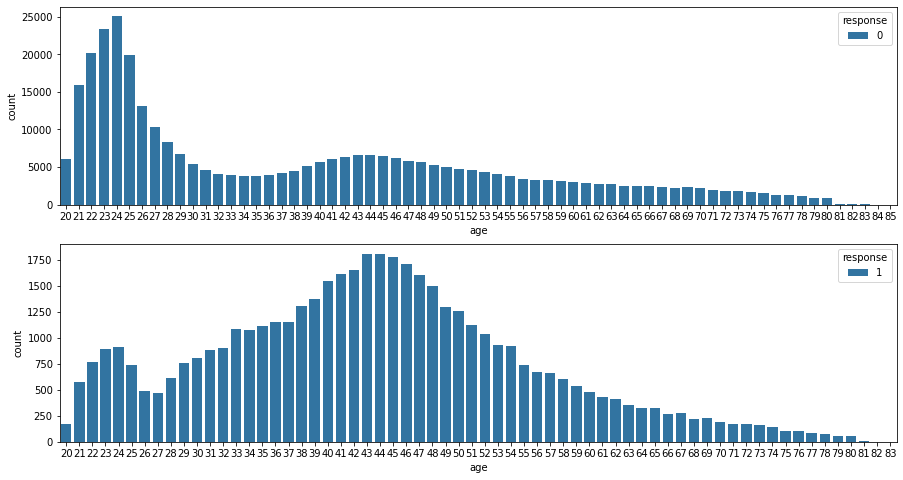

In [84]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'age', data=df3[df3['response']==0], hue='response',ax=axs[0]);
sns.countplot(x = 'age', data=df3[df3['response']==1], hue='response',ax=axs[1]);

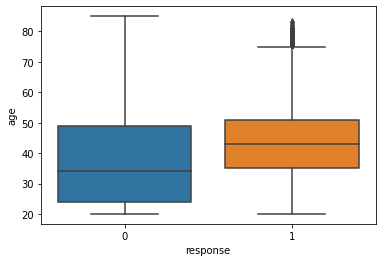

In [99]:
sns.boxplot(x= 'response', y='age', data=df3);

#### 3.1.1.2 Annual Premium

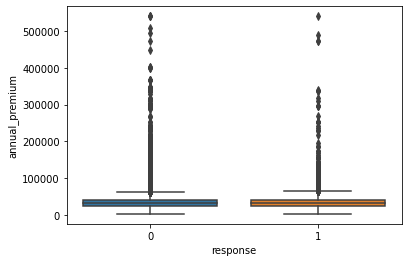

In [100]:
sns.boxplot(x= 'response', y='annual_premium', data=df3);

In [96]:
aux1=df3[(df3['annual_premium']<100000)&(df3['annual_premium']>3000)&(df3['response']==0)]
aux2=df3[(df3['annual_premium']<100000)&(df3['annual_premium']>3000)&(df3['response']==1)]
aux3=df3[(df3['annual_premium']<65000)&(df3['annual_premium']>5000)]

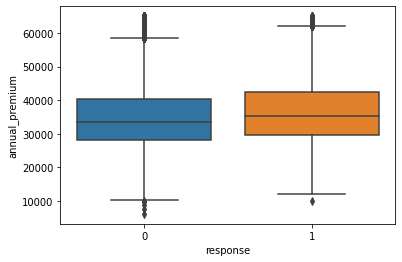

In [101]:
sns.boxplot(x= 'response', y='annual_premium', data=aux3);

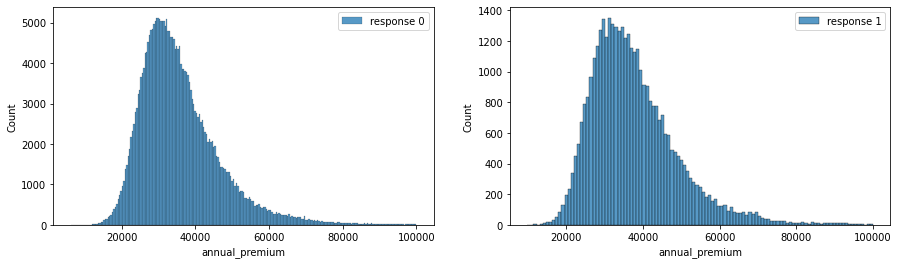

In [91]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(aux1['annual_premium'],kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['response 0'])
sns.histplot(aux2['annual_premium'],kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['response 1'])

#### 3.1.1.3 Vintage

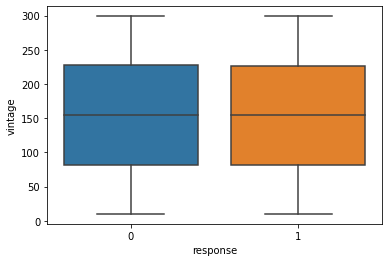

In [102]:
sns.boxplot(x= 'response', y='vintage', data=df3);

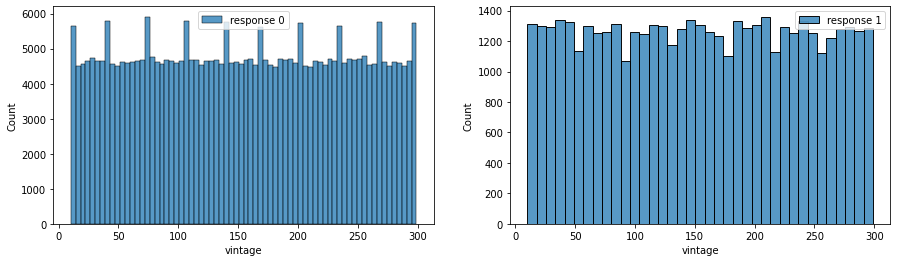

In [104]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[df3['response']==0]['vintage'],kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['response 0'])
sns.histplot(df3[df3['response']==1]['vintage'],kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['response 1'])

#### 3.1.1.4 Annual Premium per day

In [108]:
aux4= df3[df3['annual_premium_per_day']<1000]

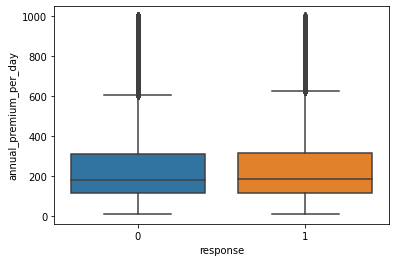

In [109]:
sns.boxplot(x= 'response', y='annual_premium_per_day', data=aux4);

#### 3.1.1.5 Annual Premium per age

In [116]:
aux5= df3[df3['annual_premium_per_age']<2500]

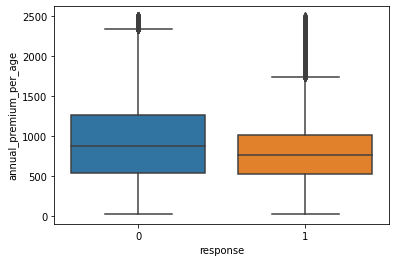

In [117]:
sns.boxplot(x= 'response', y='annual_premium_per_age', data=aux5);

#### 3.1.1.6 Vintage per age

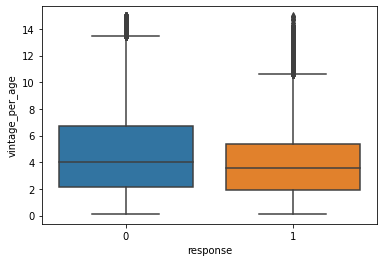

In [120]:
sns.boxplot(x= 'response', y='vintage_per_age', data=df3);

#### 3.1.1.7 Annual premium per region code annual premium mean 

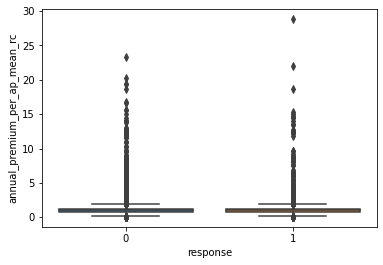

In [121]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_rc', data=df3);

In [124]:
aux6=df3[(df3['annual_premium_per_ap_mean_rc']<2)&(df3['annual_premium_per_ap_mean_rc']>1)]

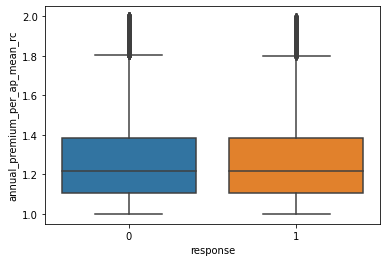

In [125]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_rc', data=aux6);

#### 3.1.1.8 Annual premium per policy sales channel annual premium mean 

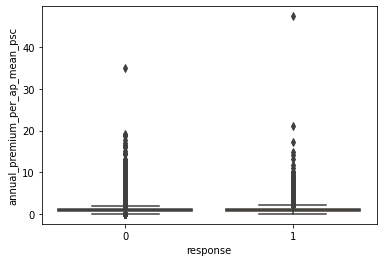

In [126]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_psc', data=df3);

In [127]:
aux7=df3[(df3['annual_premium_per_ap_mean_psc']<2)&(df3['annual_premium_per_ap_mean_psc']>1)]

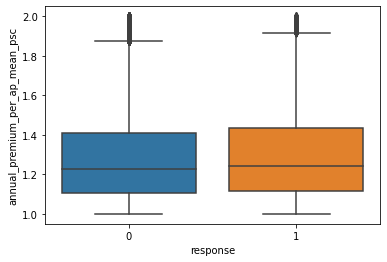

In [128]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_psc', data=aux7);

#### 3.1.1.9 Vehicle damage mean per region code

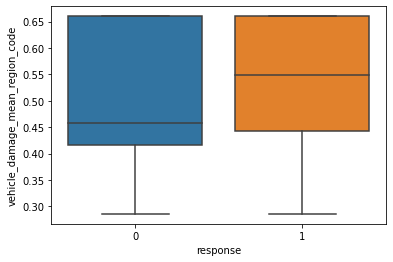

In [130]:
sns.boxplot(x= 'response', y='vehicle_damage_mean_region_code', data=df3);

### 3.1.2 Categorical Attributes

#### 3.1.2.1 Driving License

<AxesSubplot:xlabel='driving_license', ylabel='count'>

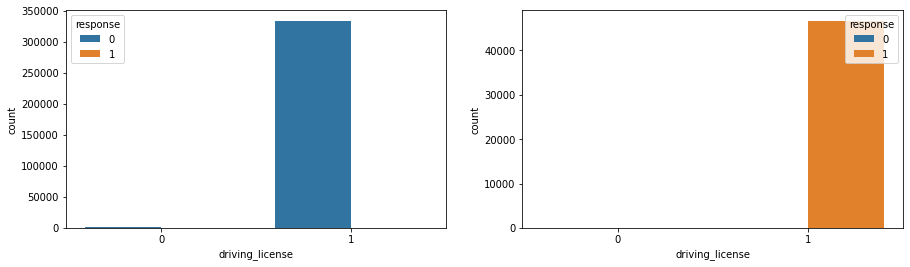

In [134]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['driving_license'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['driving_license'], hue=df3['response'], ax=axs[1])

In [156]:
pd.crosstab(df3['driving_license'], df3['response'])

response,0,1
driving_license,,
0,771,41
1,333628,46669


#### 3.1.2.2 Previously insured

<AxesSubplot:xlabel='previously_insured', ylabel='count'>

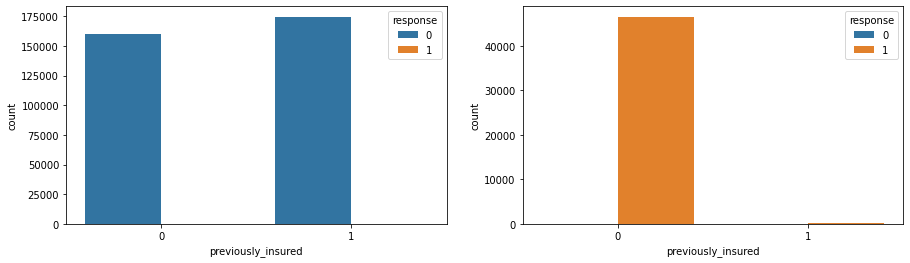

In [158]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['previously_insured'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['previously_insured'], hue=df3['response'], ax=axs[1])

In [159]:
pd.crosstab(df3['previously_insured'], df3['response'])

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


#### 3.1.2.3 Vehicle damage

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

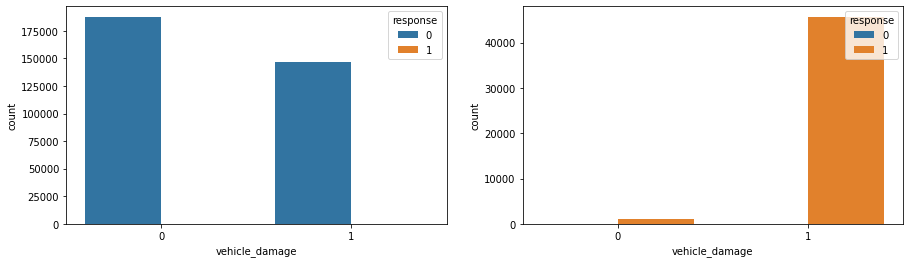

In [163]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_damage'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_damage'], hue=df3['response'], ax=axs[1])

In [170]:
aux8 = pd.crosstab(df3['vehicle_damage'], df3['response'])
aux8['percent'] = aux8[1]/(aux8[1]+aux8[0])
aux8

response,0,1,percent
vehicle_damage,,,
0,187714,982,0.005204
1,146685,45728,0.237655


#### 3.1.2.4 Vehicle age

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

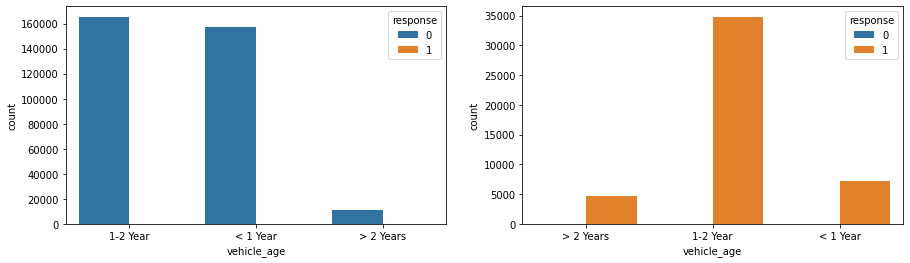

In [166]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_age'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_age'], hue=df3['response'], ax=axs[1])

In [172]:
aux9=pd.crosstab(df3['vehicle_age'], df3['response'])
aux9['percent'] = aux9[1]/(aux9[1]+aux9[0])
aux9

response,0,1,percent
vehicle_age,,,
1-2 Year,165510,34806,0.173755
< 1 Year,157584,7202,0.043705
> 2 Years,11305,4702,0.293746


#### 3.1.2.5 Gender

<AxesSubplot:xlabel='gender', ylabel='count'>

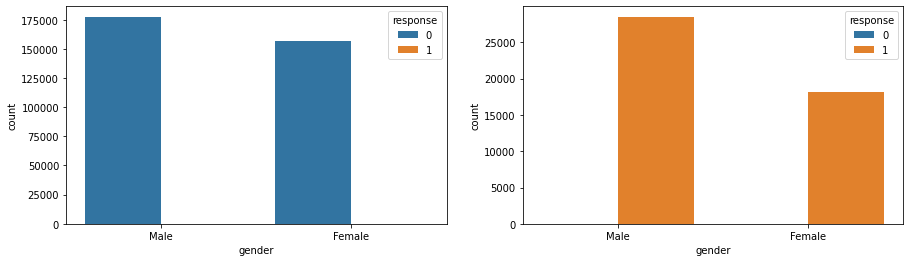

In [173]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['gender'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['gender'], hue=df3['response'], ax=axs[1])

In [174]:
aux10=pd.crosstab(df3['gender'], df3['response'])
aux10['percent'] = aux10[1]/(aux10[1]+aux10[0])
aux10

response,0,1,percent
gender,,,
Female,156835,18185,0.103902
Male,177564,28525,0.138411


#### 3.1.2.6 Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

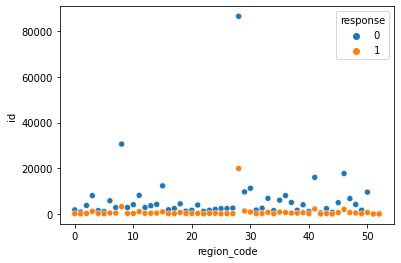

In [195]:
#fig, axs = plt.subplots(figsize = (15,4))
aux11 = df3[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x= 'region_code', y='id', hue='response', data=aux11)

#### 3.1.2.7 Policy sales channel

<AxesSubplot:xlabel='policy_sales_channel', ylabel='id'>

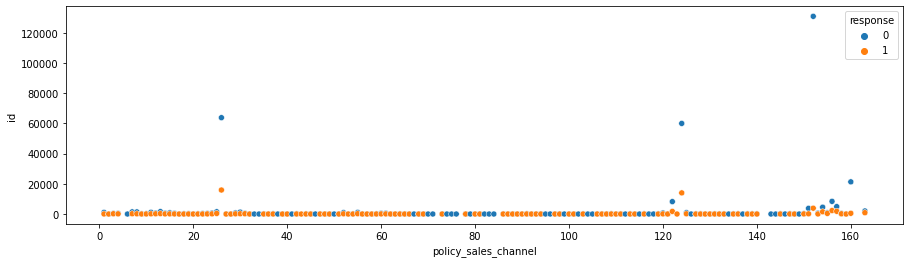

In [197]:
fig, axs = plt.subplots(figsize = (15,4))
aux11 = df3[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
sns.scatterplot(x= 'policy_sales_channel', y='id', hue='response', data=aux11)

#### 3.1.2.8 Vehicle age & vehicle damage

<AxesSubplot:xlabel='vehicle_age_vehicle_damage', ylabel='count'>

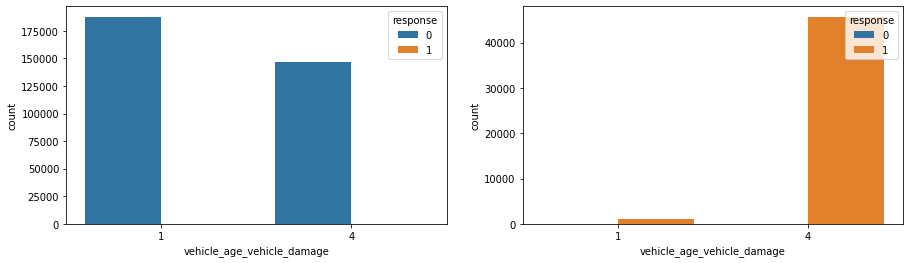

In [208]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_age_vehicle_damage'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_age_vehicle_damage'], hue=df3['response'], ax=axs[1])

In [209]:
aux12=pd.crosstab(df3['vehicle_age_vehicle_damage'], df3['response'])
aux12['percent'] = aux12[1]/(aux12[1]+aux12[0])
aux12

response,0,1,percent
vehicle_age_vehicle_damage,,,
1,187714,982,0.005204
4,146685,45728,0.237655


#### 3.1.2.9 Vehicle damage & driving license

<AxesSubplot:xlabel='vehicle_damage_license', ylabel='count'>

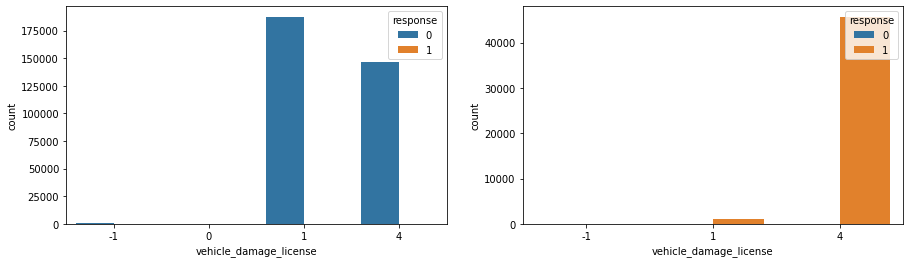

In [210]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_damage_license'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_damage_license'], hue=df3['response'], ax=axs[1])

In [211]:
aux13=pd.crosstab(df3['vehicle_damage_license'], df3['response'])
aux13['percent'] = aux13[1]/(aux13[1]+aux13[0])
aux13

response,0,1,percent
vehicle_damage_license,,,
-1,515,41,0.073741
0,256,0,0.000000
1,187458,982,0.005211
4,146170,45687,0.238130


#### 3.1.2.10 Previously insured & vehicle damage

<AxesSubplot:xlabel='previously_insured_vehicle_damage', ylabel='count'>

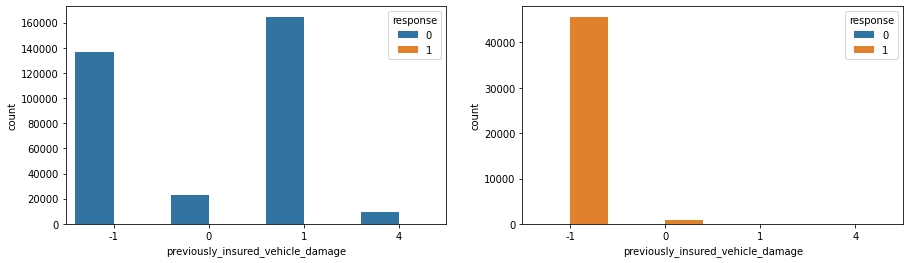

In [213]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['previously_insured_vehicle_damage'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['previously_insured_vehicle_damage'], hue=df3['response'], ax=axs[1])

In [212]:
aux14=pd.crosstab(df3['previously_insured_vehicle_damage'], df3['response'])
aux14['percent'] = aux14[1]/(aux14[1]+aux14[0])
aux14

response,0,1,percent
previously_insured_vehicle_damage,,,
-1,136849,45642,0.250105
0,23080,910,0.037932
1,164634,72,0.000437
4,9836,86,0.008668


### 3.1.3 Response Variable

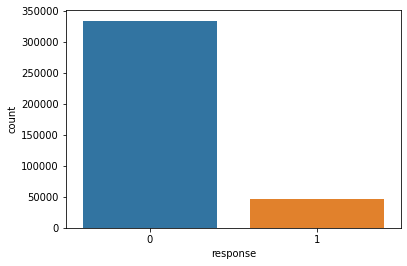

In [162]:
sns.countplot('response', data=df3);

## 3.1 Bivariate Analysis